<a href="https://colab.research.google.com/github/JimmyKeeee/DeepForest_Crown/blob/master/Building_GWP_predict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packages

In [ ]:
!pip install catboost
!pip install bayesian-optimization
!pip install merf
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 MB 9.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 12.2 MB/s eta 0:00:00


# Load packages

In [ ]:
%matplotlib inline

import seaborn as sn
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

my_seed=11

import pandas as pd
pd.set_option('display.max_columns', None)
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(my_seed)
import re
import random
random.seed(my_seed)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import hstack

from sklearn.model_selection import KFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from math import sqrt

from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
import catboost as cgb

from bayes_opt import BayesianOptimization

from statistics import mean

import warnings
warnings.filterwarnings("ignore")

# from sklearn.inspection import plot_partial_dependence

import pickle
from merf.merf import MERF
import shap
shap.initjs()

import io
import os
import shutil
from typing import List, Dict, Tuple, Union

# 0. Define helper functions

## 0.1 Define a function for feature encoding

In [ ]:
def feat_encoder(all_features: pd.DataFrame, num_feat_names: List, cat_feat_names: List, target: pd.DataFrame, rand_seed: int, retain_cat=False,**kwargs):
    """may want to try target encoding later"""

    features = all_features.copy()
    
    """check if there is any feature that needs to be dropped"""
    try:
        features.drop(kwargs['col_to_drop'],axis=1,inplace=True)
    except KeyError:
        pass
    
    # update numeric and categorical feature list
    num_feat_names = list(set(num_feat_names).intersection (set(list(features.columns))))
    cat_feat_names = list(set(cat_feat_names).intersection (set(list(features.columns))))
    
    # if exception for ohe is provided, leave out the corresponding feature(s): these feature(s) will not be encoded
    if 'ohe_exception_lst' in kwargs.keys():
        for ohe_except in kwargs['ohe_exception_lst']:
            cat_feat_names.remove(ohe_except)
          
    
    """separate train,test datasets"""
    X_train,X_test,y_train,y_test=train_test_split(features,target,random_state=rand_seed)
    #print (X_train.head())
    
    """Standardize numerical feature"""
    #ss=StandardScaler()
    #X_train[num_feat_names]=ss.fit_transform(X_train[num_feat_names])
    #X_test[num_feat_names]=ss.transform(X_test[num_feat_names])

    # check if need to retain categorical variables as-is: [CAUTION] this will retain ALL categorical features as-is, not individually
    if not(retain_cat):
        #print (cat_feat_names)
        """do label encoding for split data sets"""
        le=LabelEncoder()
        for col in cat_feat_names:
            if X_train[col].dtype == 'object':
                X_train[col] = le.fit_transform(X_train[col])
                X_test[col] = le.transform(X_test[col]) 
                integer_mapping = {l: i for i, l in enumerate(le.classes_)} #https://stackoverflow.com/questions/50834820/get-the-label-mappings-from-label-encoder
                print (f"mapping of label encoding for {col} is: ", integer_mapping, "\n")

        """OneHot Encoding for categorical features"""
        # if some categorical feature only need label encoding, drop them from cat_feat_names before ohe
        if 'le_only_lst' in kwargs:
            for feat in kwargs['le_only_lst']:
                cat_feat_names.remove(feat)
        
        ohe = OneHotEncoder(handle_unknown='ignore')
        tmp_X_train_category = ohe.fit_transform(X_train[cat_feat_names]).toarray()
        ohe_col_names = ohe.get_feature_names_out(cat_feat_names) #get encoded column names
        X_train = pd.concat([X_train.reset_index(),pd.DataFrame(tmp_X_train_category,columns=ohe_col_names)],axis=1)
        tmp_X_test_category = ohe.transform(X_test[cat_feat_names]).toarray() #transform the corresponding col in X_test
        X_test = pd.concat([X_test.reset_index(),pd.DataFrame(tmp_X_test_category,columns=ohe_col_names)],axis=1)
            
        ##remove original features
        X_train.drop(cat_feat_names,axis=1,inplace=True)
        X_test.drop(cat_feat_names,axis=1,inplace=True)
        
        ##drop the 'index' column
        X_train.drop('index',axis=1,inplace=True)
        X_test.drop('index',axis=1,inplace=True)
        
        final_col_names = list(ohe_col_names) + list(num_feat_names) #obtain the names of all encoded features
        final_cat_feat_names = list(ohe_col_names)
    else:
        final_col_names = cat_feat_names + num_feat_names #obtain the names of all encoded features
        final_cat_feat_names = cat_feat_names
        
    print (f"shape of X_train_encoded and X_test_encoded are: ", (X_train.shape, X_test.shape),"\n")
    print (f"shape of y_train and y_test are: ", (y_train.shape, y_test.shape),"\n")
    print ("cat features", final_cat_feat_names,"\n")
    print ("final features",final_col_names,"\n")
    

    return X_train,X_test,y_train,y_test,final_cat_feat_names,final_col_names

## 0.2 Define a function for training multiple models

In [ ]:
# can try 'storm tuner' library later: https://medium.com/geekculture/finding-best-hyper-parameters-for-deep-learning-model-4df7a17546c2

def multi_model(model_algorithm_dataset_dict: Dict, rand_seed: int, default_hyper_params=True, n_iter=1, **kwargs):
    """ prepare some variables """
    r2_model_FeatImportance_dict={} # a dict { r2: (model_name, feature_importance) }
    
    if default_hyper_params:    
        """ loop over all models """
        for model_name, algorithm_data_tuple in model_algorithm_dataset_dict.items():
            """ loop over iterations """
            for i in range(n_iter):   
                """ loop over all datasets (i.e., multiple datasets can be fed to this function to train model) """        
                for j in range(len(algorithm_data_tuple[1])): 
                    # prepare the train and test data
                    X = algorithm_data_tuple[1][j][0] #2nd element in 'algorithm_data_tuple' is the (j) nested lists of [d_base[X_train,X_test,y_train,y_test,final_cat_feat_names],...
                                                    #,d_geo4]; assign X_train to X
                    y = algorithm_data_tuple[1][j][2] #assign y_train to y
                    X_test = algorithm_data_tuple[1][j][1] 
                    y_test = algorithm_data_tuple[1][j][3]
                    cat_feat_names = algorithm_data_tuple[1][j][4]
                    final_col_names = algorithm_data_tuple[1][j][5]

                    # specify the categorical features, if CatGB is selected
                    if model_name == 'CatBoostRegressor':
                        categorical_features_indices = [X.columns.get_loc(cat_feat) for cat_feat in cat_feat_names]
                    
                    # create an object, fit (k-fold validation) and make prediction
                    regr_obj = algorithm_data_tuple[0] #1st element in 'algorithm_data_tuple' is the actual algorithm            
                    kf = KFold(random_state=rand_seed, shuffle=True)
                    score_lst = []

                    # k-fold validation
                    for train_ix, test_ix in kf.split(X):
                        X_train_tmp, X_test_tmp = X.iloc[train_ix], X.iloc[test_ix]
                        y_train_tmp, y_test_tmp = y.iloc[train_ix], y.iloc[test_ix]

                        # fit the model
                        try: #if CatGB is selected
                            regr_obj.fit(X_train_tmp,y_train_tmp,cat_features=categorical_features_indices)
                        except:
                            regr_obj.fit(X_train_tmp,y_train_tmp)

                        # make prediction and add score to the list 
                        score_lst.append(r2_score(y_test_tmp,regr_obj.predict(X_test_tmp)))

                        # print out the average training score
                        print ("Default hyperparams, out of ", len(score_lst), "folds, ", f"average r2 of {model_name} from K-Fold validation is: ",mean(score_lst),"\n")

                    # pickle the model
                    pkl_filename = f"pickle_{model_name}_{j}th dataset.pkl"
                    with open(pkl_filename, 'wb') as file:
                        pickle.dump(regr_obj, file)
                        
                    # store the test score
                    r2_test = r2_score(y_test, regr_obj.predict(X_test))
                    # store the score on entire dataset
                    X_reunited = pd.concat([X,X_test])
                    y_reunited = pd.concat([y,y_test])
                    r2_whole = r2_score(y_reunited,regr_obj.predict(X_reunited))
                    
                    # get feature importance from the best model
                    feat_importances = pd.Series(regr_obj.feature_importances_ , index=final_col_names)
                    #print (feat_importances)
                        
                    print (f"{i}th iteration, {j}th dataset, the test r2 of {model_name} is: ", r2_test,"\n")
                    print (f"{i}th iteration, {j}th dataset, the r2 of {model_name} on ENTIRE dataset is: ", r2_whole,"\n")
                    print (f"{i}th iteration, {j}th dataset, the AVERAGE groundtruth value of {model_name} is: ", np.average(y_test),"\n")
                    print (f"{i}th iteration, {j}th dataset, the AVERAGE predicted value of {model_name} is: ", np.average(regr_obj.predict(X_test)),"\n")
                    print (f"{i}th iteration, {j}th dataset, the RMSE of {model_name} is: ", sqrt(mean_squared_error(y_test,regr_obj.predict(X_test))),"\n""\n")
                    
                    # add information
                    r2_model_FeatImportance_dict[r2_test] = (model_name,f"{j}th dataset",feat_importances,pkl_filename, [X,y])
                    #print ( r2_model_FeatImportance_dict)
                    
    else:    
        """ with hyperparams tuning """
        assert isinstance(kwargs['hyperparams_range_dict'],dict) #check if the nested dict { model_name1: {hparam1: x, hparam2: y,...hparamX: z},... } is provided
        
        """ loop over all models """
        for model_name, algorithm_data_tuple in model_algorithm_dataset_dict.items():
            
            # special handling for CatGB
            if model_name == 'CatBoostRegressor':
                """define a helper function for CatGB"""
                def hyp_cat(depth,bagging_temperature):
                    params={'iterations':300,
                            'learning_rate':0.05,
                            'eval_metric': 'R2',
                            'verbose':False,    
                    }

                    params['depth']=int(round(depth))
                    params['bagging_temperature']=bagging_temperature
                    params['loss_function']= "RMSE"
                    scores_cgb=cgb.cv(cv_dataset,params,fold_count=5)
                    
                    return np.max(scores_cgb['test-R2-mean'])
                    
                # prepare other variables
                pds={'depth': kwargs['hyperparams_range_dict']['CatBoostRegressor']['depth'],
                     'bagging_temperature':kwargs['hyperparams_range_dict']['CatBoostRegressor']['bagging_temperature'],
                    }   
                     
            """ loop over iterations """
            for i in range(n_iter):   
                """loop over all datasets (i.e., base, cluster, geoclass6, geoclass3,geoclass4)"""        
                for j in range(len(algorithm_data_tuple[1])): 
                    # prepare the train and test data
                    X_train = algorithm_data_tuple[1][j][0] #2nd element in 'algorithm_data_tuple' is the (j) nested lists of [d_base[X_train,X_test,y_train,y_test,final_cat_feat_names],...
                                                    #,d_geo4]; 
                    y_train = algorithm_data_tuple[1][j][2] 
                    X_test = algorithm_data_tuple[1][j][1] 
                    y_test = algorithm_data_tuple[1][j][3]
                    cat_feat_names = algorithm_data_tuple[1][j][4]
                    final_col_names = algorithm_data_tuple[1][j][5]

                    # special handling for CatGB
                    if model_name == 'CatBoostRegressor':
                        categorical_features_indices = [X_train.columns.get_loc(cat_feat) for cat_feat in cat_feat_names]
                        cv_dataset = cgb.Pool(data=X_train,label=y_train,cat_features=categorical_features_indices)
                        #internal_params_CatGB={k:v for k,v in kwargs['hyperparams_range_dict']['CatBoostRegressor'].items() if k in ['iterations','learning_rate','eval_metric',
                                                                                                                          #'verbose']}
                        #create an optimizer model
                        optimizer = BayesianOptimization(hyp_cat,pds) #hyp_cat and pds are defined where 'model_name' is first identified

                        #optimize
                        try:
                            optimizer.maximize(init_points=3,n_iter=7)
                            best_params = optimizer.max['params']
                            print ("Hyperparams of the best model: ", best_params)
                        except ValueError as err:
                            print (f"{err}")
                            print ("The following is skpped: ","\n", f"{i}th iteration, {j}th dataset, {model_name}","\n")
                            continue
                        
                        # create the CatGB object with optimal hyperparams
                        # [caution] make sure 'verbose' and 'n_estimators' have the same values as those in no hyperparams tuning case
                        regr_obj = CatBoostRegressor(random_state=rand_seed,verbose=0,n_estimators=2000,bagging_temperature=optimizer.max['params']['bagging_temperature'],depth=int(round(optimizer.max['params']['depth'])))

                        # fit the model
                        regr_obj.fit(X_train,y_train,cat_features=categorical_features_indices)
                    else:
                        # create an object and make prediction
                        regr_obj = algorithm_data_tuple[0] #1st element in 'algorithm_data_tuple' is the actual algorithm 

                        # do the random search CV
                        regr_obj_random = RandomizedSearchCV(estimator = regr_obj, param_distributions = kwargs['hyperparams_range_dict'][model_name], 
                                                             n_iter = 100, cv = 5, scoring='r2',verbose=2, random_state=rand_seed, n_jobs = -1)
                        regr_obj_random.fit(X_train,y_train)

                        # assign the best model back to regr_obj
                        regr_obj = regr_obj_random.best_estimator_
                        best_params  =regr_obj_random.best_params_ #save the hyperparams of the best model
                        print ("Hyperparams of the best model: ", best_params)
                        
                        # do the training based on the best model
                        regr_obj.fit(X_train,y_train)
                        
                    # pickle the model
                    pkl_filename = f"pickle_{model_name}_{j}th dataset.pkl"
                    with open(pkl_filename, 'wb') as file:
                        pickle.dump(regr_obj, file)
                        
                    # get feature importance from the best model
                    feat_importances = pd.Series(regr_obj.feature_importances_ , index=final_col_names)

                    # store the test score
                    r2_test = r2_score(y_test, regr_obj.predict(X_test))
                    # store the score on entire dataset
                    X_reunited = pd.concat([X_train,X_test])
                    y_reunited = pd.concat([y_train,y_test])
                    r2_whole = r2_score(y_reunited,regr_obj.predict(X_reunited))
                    
                    print (f"{i}th iteration, {j}th dataset, the test r2 of {model_name} is: ", r2_test,"\n")
                    print (f"{i}th iteration, {j}th dataset, the r2 of {model_name} on ENTIRE dataset is: ", r2_whole,"\n")
                    print (f"{i}th iteration, {j}th dataset, the AVERAGE groundtruth value of {model_name} is: ", np.average(y_test),"\n")
                    print (f"{i}th iteration, {j}th dataset, the AVERAGE predicted value of {model_name} is: ", np.average(regr_obj.predict(X_test)),"\n")
                    print (f"{i}th iteration, {j}th dataset, the RMSE of {model_name} is: ", sqrt(mean_squared_error(y_test,regr_obj.predict(X_test))),"\n""\n")

                    ##add information
                    r2_model_FeatImportance_dict[r2_test]=(model_name,f"{j}th dataset",feat_importances,pkl_filename,[X_train,y_train])
       
    
    """ feature importance from best model """
    # identify the feature importance from the best model
    tmp_r2 = 0
    for r2 in list(r2_model_FeatImportance_dict.keys()):
        tmp_r2 = max(tmp_r2,r2)
    model_w_highest_r2 = r2_model_FeatImportance_dict[tmp_r2][0] #points to 'model_name'
    data_set_w_highest_r2 = r2_model_FeatImportance_dict[tmp_r2][1] #points to corresponding 'jth dataset'
    feat_importances_best = r2_model_FeatImportance_dict[tmp_r2][2] #points to corresponding 'feat_importances'
    best_pickle_name = r2_model_FeatImportance_dict[tmp_r2][3] #points to the name of the pickled best model
    best_train_Xy_data = r2_model_FeatImportance_dict[tmp_r2][4] #points to the [X_train, y_train] data that was used to train the best model
    #print (feat_importances_best)

    # save the best performing model
    src = os.path.sep.join([os.getcwd(),f"{best_pickle_name}"])
    dst = os.path.sep.join([os.getcwd(),f"BEST_performing_model.pkl"])
    shutil.copy(src,dst)
   
    
    # plot and save the feature importance
    print (f"the feature importance (top 15) of the model with highest r2 ({tmp_r2}), {model_w_highest_r2} & {data_set_w_highest_r2}, is shown below: \n")
    feat_importances_best.nlargest(15).plot(kind='barh')
    
    fig = feat_importances_best.nlargest(15).plot(kind='barh').get_figure()
    fig.savefig('feature_importance from best model.png')
    
    
    """ partial dependence plot from best model 
    # prepare best model
    best_model = pickle.load(open(best_pickle_name, 'rb'))
    #print (f"r2 of PICKLED BEST model using ALL of its own training dataset: ",r2_score(best_train_Xy_data[1],best_model.predict(best_train_Xy_data[0])),"\n")
    
    #[Caution] seems you'll have to fit the loaded model for CatBoost again before using PDP (no such a need for RF or LightGBM)
    #best_model.fit( best_train_Xy_data[0], best_train_Xy_data[1])-->this won't work for CatBoost, as it does not use the standard sklearn API
    
    # plot PDP using PDP plot from sklearn
    plot_partial_dependence(best_model,  best_train_Xy_data[0], list(feat_importances_best.index),n_jobs=-1, grid_resolution=20)
    

    
    # adjust size, display and save figure
    fig=plt.gcf()
    fig.set_size_inches(16,10)
    print (f"Partial dependence plot for {model_w_highest_r2} & {data_set_w_highest_r2} is shown below: \n")
    fig.subplots_adjust(wspace=0.2, hspace=0.3)
    fig.savefig(f"PDP from best model_{model_w_highest_r2} & {data_set_w_highest_r2}.png")
    """
    
    
    
    

## 0.3 Define a function for SHAP analysis

In [ ]:
# https://github.com/MAIF/shapash (try later)

def SHAP_anal(trained_model, data_input_for_anal, **kwargs):
  # initiate an explainer object and obtain SHAP values
  explainer = shap.TreeExplainer(trained_model)
  shap_values = explainer.shap_values(data_input_for_anal)

  # generate and save feature importance plot
  shap.summary_plot(shap_values, data_input_for_anal, plot_type="bar")
  plt.gcf().savefig(f"feature importance plot.png",dpi=600)

  # generate and save summary plot
  shap.summary_plot(shap_values, data_input_for_anal, show=False)
  plt.gcf().savefig(f"SHAP summary plot.png",dpi=600)

  # dependence plot
  if 'feat_for_depend_plt_lst' in kwargs:
    # 'feat_for_depend_plt_lst' points to a list of features for dependence plot
    # generate and save dependence plot for any given feature
    for i, feat in enumerate(kwargs['feat_for_depend_plt_lst']):
        shap.dependence_plot(feat,shap_values, data_input_for_anal, show=False)
        plt.gcf().savefig(f"SHAP dependence plot for {feat}.png",dpi=600)
  

# 1.0 Data preprocesssing

In [ ]:
file_name = 'EU-ECB_dataset_feature_engineered.csv' # file name MUST match the file selected for upload

# load data file from local drive
from google.colab import files
uploaded = files.upload()


Saving EU-ECB_dataset_feature_engineered.csv to EU-ECB_dataset_feature_engineered.csv


In [ ]:
# convert data file into dataframe
raw_all = pd.read_csv(io.BytesIO(uploaded[file_name]))

In [ ]:
raw_all.head()

,site_country_code,admin_project_code,admin_data_partner,admin_project_contact,bldg_use_type,bldg_use_subtype,bldg_project_status,site_country,bldg_year_permit,bldg_year_complete,bldg_year_complete_interval,bldg_QTO_type,bldg_area_definition,bldg_area_gfa,bldg_area_hfa,bldg_area_interval,bldg_users_total,bldg_floors_ag,bldg_floors_bg,bldg_struct_type,bldg_roof_type,bldg_energy_class_general,bldg_energy_class_country,bldg_certification,inv_energy_consumption,inv_mat_mass_total,inv_mat_mass_total_m2,inv_mat_mass_total_capita,inv_mat_mass_sum_top_5,inv_mat_mass_ratio,inv_mat_1_type,inv_mat_1_mass,inv_mat_2_type,inv_mat_2_mass,inv_mat_3_type,inv_mat_3_mass,inv_mat_4_type,inv_mat_4_mass,inv_mat_5_type,inv_mat_5_mass,mass_aluminium,mass_bamboo,mass_brass_copper,mass_cement_mortar,mass_ceramics,mass_concrete_reinforced,mass_concrete_wo_reinforcement,mass_earth,mass_EPS_XPS,mass_fungi,mass_glass,mass_metals,mass_plastics,mass_steel_reinforcement,mass_stone,mass_stone_wool,mass_straw_hemp,mass_wood,mass_other,eurostat_metal_materials,eurostat_non-metallic_minerals,eurostat_fossil_energy_materials,eurostat_biomass_based_materials,lca_RSP,lca_software,lca_database,lca_scenarios_decarbonisation,scope_parts,scope_LCS,scope_LCM,scope_parts_1_ground,scope_parts_2_structure,scope_parts_3_secondary,scope_parts_4_finishes,scope_parts_5_mechanical,scope_parts_6_electrical,scope_parts_6+_renewables,scope_parts_7_facilities,scope_parts_8_fittings,scope_LCS_A123,scope_LCS_A4,scope_LCS_A5,scope_LCS_B1,scope_LCS_B2,scope_LCS_B3,scope_LCS_B4,scope_LCS_B5,scope_LCS_B6,scope_LCS_B7,scope_LCS_B8,scope_LCS_C1,scope_LCS_C2,scope_LCS_C3,scope_LCS_C4,scope_LCS_D,scope_handling_D,GHG_sum_em,GHG_sum_em_m2a,GHG_sum_em_capita_a,GHG_A_m2a,GHG_B_em_m2a,GHG_B_op_m2a,GHG_C_m2a,GHG_A_capita_a,GHG_B_em_capita_a,GHG_B_op_capita_a,GHG_C_capita_a,GHG_A1_m2a,GHG_A2_m2a,GHG_A3_m2a,GHG_A4_m2a,GHG_A5_m2a,GHG_B1_m2a,GHG_B2_m2a,GHG_B3_m2a,GHG_B4_m2a,GHG_B6_m2a,GHG_B7_m2a,GHG_C1_m2a,GHG_C2_m2a,GHG_C3_m2a,GHG_C4_m2a,GHG_A123_m2a,GHG_A45_m2a,GHG_B1234_m2a,GHG_B5_m2a,GHG_B67_m2a,GHG_C12_m2a,GHG_C34_m2a,GHG_D_m2a,GHG_A123_m2a_APEN,GHG_A45_m2a_APEN,GHG_B1234_m2a_APEN,GHG_B5_m2a_APEN,GHG_B67_m2a_APEN,GHG_C12_m2a_APEN,GHG_C34_m2a_APEN,GHG_D_m2a_APEN,GHG_sum_em_m2a_APEN,GHG_sum_op_m2a_APEN,GHG_A123_m2a_harm,GHG_A45_m2a_harm,GHG_B1234_m2a_harm,GHG_B5_m2a_harm,GHG_B67_m2a_harm,GHG_C12_m2a_harm,GHG_C34_m2a_harm,GHG_sum_em_m2a_harm,GHG_A123_m2a_harm_LCM,GHG_A45_m2a_harm_LCM,GHG_B1234_m2a_harm_LCM,GHG_B5_m2a_harm_LCM,GHG_C12_m2a_harm_LCM,GHG_C34_m2a_harm_LCM,GHG_P1_sum_m2a,GHG_P1_A123_m2a,GHG_P1_A45_m2a,GHG_P1_B1234_m2a,GHG_P1_B5_m2a,GHG_P1_C12_m2a,GHG_P1_C34_m2a,GHG_P1_D_m2a,GHG_P2_sum_m2a,GHG_P2_A123_m2a,GHG_P2_A45_m2a,GHG_P2_B1234_m2a,GHG_P2_B5_m2a,GHG_P2_C12_m2a,GHG_P2_C34_m2a,GHG_P2_D_m2a,GHG_P34_sum_m2a,GHG_P34_A123_m2a,GHG_P34_A45_m2a,GHG_P34_B1234_m2a,GHG_P34_B5_m2a,GHG_P34_C12_m2a,GHG_P34_C34_m2a,GHG_P34_D_m2a,GHG_P4_sum_m2a,GHG_P4_A123_m2a,GHG_P4_A45_m2a,GHG_P4_B1234_m2a,GHG_P4_B5_m2a,GHG_P4_C12_m2a,GHG_P4_C34_m2a,GHG_P4_D_m2a,GHG_P56_sum_m2a,GHG_P56_A123_m2a,GHG_P56_A45_m2a,GHG_P56_B1234_m2a,GHG_P56_B5_m2a,GHG_P56_C12_m2a,GHG_P56_C34_m2a,GHG_P56_D_m2a,GHG_P78_sum_m2a,GHG_P78_A123_m2a,GHG_P78_A45_m2a,GHG_P78_B1234_m2a,GHG_P78_B5_m2a,GHG_P78_C12_m2a,GHG_P78_C34_m2a,GHG_P78_D_m2a,GHG_sum_em_m2pertonGHG_a,GHG_sum_em_m2pertonGHG,GHG_sum_op_m2pertonGHG_a,GHG_sum_op_m2pertonGHG,GHG_sum_em_cappertonGHG_a,GHG_sum_em_cappertonGHG,GHG_sum_op_cappertonGHG_a,GHG_sum_op_cappertonGHG,ratio_A123_LCM,ratio_A45_LCM,ratio_B1234_LCM,ratio_B5_LCM,ratio_C12_LCM,ratio_C34_LCM,ratio_A123_parts,ratio_A45_parts,ratio_B1234_parts,ratio_B5_parts,ratio_C12_parts,ratio_C34_parts
0,DK,BUILD01,BUILD,BUILD,Non-residential,Other,New Built,Denmark,NaN,NaN,2015-2019,As-built measurement,Denmark (BR18),NaN,NaN,15001-20000,NaN,NaN,NaN,No data,NaN,New Standard,2015,No certification,NaN,53200000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

## 1.1 Exploratory data analysis

## 1.2 Feature screening and engineering

In [ ]:
""" define the scope of analysis """
raw_df = raw_all[raw_all.bldg_project_status.isin(['New Built', 'In use'])]

# Sub-sets
raw_df_DK = raw_df[raw_df.site_country.isin(['Denmark']) & raw_df.admin_project_contact.isin(['BUILD', 'Ramboll'])]
raw_df_FR = raw_df[raw_df.site_country.isin(['France']) & raw_df.admin_project_contact.isin(['CSTB'])]
raw_df_BE = raw_df[raw_df.site_country.isin(['Belgium']) & raw_df.admin_project_contact.isin(['KU Leuven'])]
raw_df_NL = raw_df[raw_df.site_country.isin(['Netherlands']) & raw_df.admin_project_contact.isin(['NIBE'])]
raw_df_FI = raw_df[raw_df.site_country.isin(['Finland']) & raw_df.admin_project_contact.isin(['Granlund Oy', 'Bionova'])]

raw_df_A72 = raw_df[raw_df.admin_project_contact.isin(['ROECK-et-al', 'AMIRI-et-al'])]

raw_df_EUECB = raw_df_DK.append([raw_df_FR, raw_df_BE, raw_df_NL, raw_df_FI])

raw_df_EUECB.shape

# assign final sub-set to raw_df for further processing
raw_df = raw_df_EUECB

In [ ]:
""" decide target column(s) to keep """
# remove the columns with too much missing data
target_col_set = {col for col  in raw_df.columns if col.startswith('GHG')}
missing_data_percent_dict = {col: raw_df[col].isnull().sum()/len(raw_df[col]) for col in target_col_set }
missing_threshold = 0.5
target_col_set_retained = {col for col in target_col_set if missing_data_percent_dict[col] <= missing_threshold}
#print(target_col_set_retained)

# update the dataframe
data_updated = raw_df.drop(list(target_col_set-target_col_set_retained), axis=1)
print([col for col in data_updated.columns if col.startswith('GHG')])

['GHG_sum_em', 'GHG_sum_em_m2a', 'GHG_sum_em_capita_a', 'GHG_B67_m2a', 'GHG_B67_m2a_harm', 'GHG_sum_em_m2a_harm', 'GHG_A123_m2a_harm_LCM', 'GHG_A45_m2a_harm_LCM', 'GHG_B1234_m2a_harm_LCM', 'GHG_C12_m2a_harm_LCM', 'GHG_C34_m2a_harm_LCM', 'GHG_P1_sum_m2a', 'GHG_P2_sum_m2a', 'GHG_P34_sum_m2a', 'GHG_P4_sum_m2a', 'GHG_P56_sum_m2a', 'GHG_P78_sum_m2a', 'GHG_sum_em_m2pertonGHG_a', 'GHG_sum_em_m2pertonGHG', 'GHG_sum_op_m2pertonGHG_a', 'GHG_sum_op_m2pertonGHG', 'GHG_sum_em_cappertonGHG_a', 'GHG_sum_em_cappertonGHG']


In [ ]:
""" decide feature columns to keep """
# remove the columns with too much missing data
feat_col_set = {col for col in data_updated.columns if col not in target_col_set_retained}
feat_col_set_retained = {col for col in feat_col_set if data_updated[col].isnull().sum()/len(data_updated[col]) <= missing_threshold}
#print(feat_col_set_retained)

# further screening
further_removal_set = {'admin_','site_country','scope_','lca_database','lca_software'}
for start_str in further_removal_set:
  feat_col_set_retained = {col for col in feat_col_set_retained if not col.startswith(start_str)}

# update the dataframe
data_updated = data_updated.drop(list(feat_col_set-feat_col_set_retained), axis=1)

# exam the retained features
data_updated

,bldg_use_type,bldg_use_subtype,bldg_project_status,bldg_year_complete_interval,bldg_area_definition,bldg_area_gfa,bldg_area_interval,bldg_users_total,bldg_floors_ag,bldg_floors_bg,bldg_struct_type,bldg_roof_type,bldg_energy_class_general,bldg_energy_class_country,inv_mat_1_type,lca_RSP,lca_scenarios_decarbonisation,GHG_sum_em,GHG_sum_em_m2a,GHG_sum_em_capita_a,GHG_B67_m2a,GHG_B67_m2a_harm,GHG_sum_em_m2a_harm,GHG_A123_m2a_harm_LCM,GHG_A45_m2a_harm_LCM,GHG_B1234_m2a_harm_LCM,GHG_C12_m2a_harm_LCM,GHG_C34_m2a_harm_LCM,GHG_P1_sum_m2a,GHG_P2_sum_m2a,GHG_P34_sum_m2a,GHG_P4_sum_m2a,GHG_P56_sum_m2a,GHG_P78_sum_m2a,GHG_sum_em_m2pertonGHG_a,GHG_sum_em_m2pertonGHG,GHG_sum_op_m2pertonGHG_a,GHG_sum_op_m2pertonGHG,GHG_sum_em_cappertonGHG_a,GHG_sum_em_cappertonGHG,ratio_A123_LCM,ratio_A45_LCM,ratio_B1234_LCM,ratio_C12_LCM,ratio_C34_LCM,ratio_A123_parts,ratio_A45_parts,ratio_B1234_parts,ratio_B5_parts,ratio_C12_parts,ratio_C34_parts
0,Non-residential,Other,New Built,2015-2019,Denmark (BR18),NaN,15001-20000,NaN,NaN,NaN,No data,NaN,New Standard,2015,NaN,50.0,No,NaN,8.090000,NaN,3.50,3.50,8.090000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123.609394,2.472188,285.714286,5.714286,NaN,NaN,0.498146,NaN,0.297899,NaN,0.203956,0.498146,NaN,0.297899,NaN,NaN,0.203956
1,Non-residential,Other,New Built,2015-2019,Denmark (BR18),NaN,15001-20000,NaN,NaN,NaN,No data,NaN,New Standard,2015,NaN,50.0,No,NaN,6.290000,NaN,3.50,3.50,6.290000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158.982512,3.179650,285.714286,5.714286,NaN,NaN,0.275040,NaN,0.303657,NaN,0.421304,0.275040,NaN,0.303657,NaN,NaN,0.421304
2,Non-residential,Other,New Built,2015-2019,Denmark (BR18),9819.0,5001-10000,NaN,NaN,NaN,No data,NaN,New Advanced,2020,NaN,50.0,No,NaN,9.800000,NaN,2.67,2.67,9.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,102.040816,2.040816,374.531835,7.490637,NaN,NaN,0.852041,NaN,0.066327,NaN,0.081633,0.852041,NaN,0.066327,NaN,NaN,0.081633
3,Non-residential,Other,New Built,2015-2019,Denmark (BR18),19518.0,15001-20000,NaN,NaN,NaN,No data,NaN,New Standard,2015,NaN,50.0,No,NaN,7.300000,NaN,2.69,2.69,7.300000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,136.986301,2.739726,371.747212,7.434944,NaN,NaN,0.846575,NaN,0.095890,NaN,0.057534,0.846575,NaN,0.095890,NaN,NaN,0.057534
4,Residential,Multi-family house,New Built,2015-2019,Denmark (BR18),NaN,10001-15000,NaN,NaN,NaN,No data,NaN,New Standard,2015,NaN,50.0,No,NaN,6.190000,NaN,2.09,2.09,6.190000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.550889,3.231018,478.468900,9.569378,NaN,NaN,0.791599,NaN,0.063005,NaN,0.145396,0.791599,NaN,0.063005,NaN,NaN,0.145396
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
296,Residential,Single family house,New Built,2020-Today,Finland,264.0,0-5000,4.0,1.0,0.0,massive wood,Single pitched roof,New Standard,B,"Timber, wood",50.0,Yes,NaN,9.500000,627.000000,5.40,5.40,9.500000,NaN,NaN,NaN,NaN,NaN,NaN,4.4,1.80,0.40,0.90,0.2,105.263158,2.105263,185.185185,3.703704,1.594896,0.031898,-0.842105,0.115789,0.063158,0.037880,1.625278,-0.842105,0.115789,0.063158,NaN,0.037880,1.625278
297,Residential,Single family house,New Built,2020-Today,Finland,147.0,0-5000,3.0,1.0,0.0,frame wood,Gable or saddle roof,New Standard,B,"Timber, wood",50.0,Yes,NaN,6.900000,338.100000,5.50,5.50,6.900000,NaN,NaN,NaN,NaN,NaN,NaN,1.9,2.50,0.20,0.60,0.2,144.927536,2.898551,181.818182,3.636364,2.957705,0.059154,-0.739130,0.159420,0.072464,0.040133,1.467113,-0.739130,0.159420,0.072464,NaN,0.040133,1.467113
298,Non-residential,Mixed use,New Built,2020-Today,Finland,3134.0,0-5000,54.0,3.0,0.0,frame concrete,Single pitched roof,New Standard,B,Concrete reinforced,50.0,Yes,NaN,16.200000,940.200000,11.50,11.50,16.200000,NaN,NaN,NaN,NaN,NaN,NaN,6.9,2.40,1.30,2.90,0.4,61.728395,1.234568,86.956522,1.739130,1.063603,0.021272,0.777778,0.074074,0.018519,0.030908,0.098722,0.777778,0.074074,0.

In [ ]:
# correlation screening
# a python package to remove collinearity: https://towardsdatascience.com/a-python-library-to-remove-collinearity-5a4eb05d3d73

# variance screening

# remove the rows containing NaN in feature and/or target columns
data_updated.dropna(inplace=True)
data_updated

# create a dict to store dtype of each column
dtype_dict = {col: data_updated[col].dtype for col in data_updated.columns}
dtype_dict

{'bldg_use_type': dtype('O'),
 'bldg_use_subtype': dtype('O'),
 'bldg_project_status': dtype('O'),
 'bldg_year_complete_interval': dtype('O'),
 'bldg_area_definition': dtype('O'),
 'bldg_area_gfa': dtype('float64'),
 'bldg_area_interval': dtype('O'),
 'bldg_users_total': dtype('float64'),
 'bldg_floors_ag': dtype('float64'),
 'bldg_floors_bg': dtype('float64'),
 'bldg_struct_type': dtype('O'),
 'bldg_roof_type': dtype('O'),
 'bldg_energy_class_general': dtype('O'),
 'bldg_energy_class_country': dtype('O'),
 'inv_mat_1_type': dtype('O'),
 'lca_RSP': dtype('float64'),
 'lca_scenarios_decarbonisation': dtype('O'),
 'GHG_sum_em': dtype('float64'),
 'GHG_sum_em_m2a': dtype('float64'),
 'GHG_sum_em_capita_a': dtype('float64'),
 'GHG_B67_m2a': dtype('float64'),
 'GHG_B67_m2a_harm': dtype('float64'),
 'GHG_sum_em_m2a_harm': dtype('float64'),
 'GHG_A123_m2a_harm_LCM': dtype('float64'),
 'GHG_A45_m2a_harm_LCM': dtype('float64'),
 'GHG_B1234_m2a_harm_LCM': dtype('float64'),
 'GHG_C12_m2a_harm_LCM

## 1.3 Feature encoding

In [ ]:
# shared variables
algorithm_data_dict = {} # {algorithm: nested list of datasets}

### 1.3.1 prepare train and test data for random forest

In [ ]:
features_=data_updated[list(feat_col_set_retained)]
cat_feat_names=[col for col in features_.columns if data_updated[col].dtype == 'object']
num_feat_names=[feat for feat in features_.columns if feat not in cat_feat_names]
target_=data_updated['GHG_sum_em']

# get data into a list
X_train,X_test,y_train,y_test,final_cat_feat_names,final_col_names = feat_encoder(features_,num_feat_names,cat_feat_names,
                                                           target_,rand_seed=my_seed,retain_cat=False) #set retain_cat=True if wanting to use catboost, include cat features in analysis
d_base_rf = [X_train,X_test,y_train,y_test,final_cat_feat_names,final_col_names]

# print dtype of each feature col
#dtype_dict = {col: X_train[col].dtype for col in X_train.columns}
#print (dtype_dict)

# store different datasets (if any) in one dict
algorithm_data_dict['RandomForestRegressor'] = [d_base_rf] # nested list of datasets (i.e., can be more than just 'd_base_rf')



mapping of label encoding for bldg_energy_class_general is:  {'New Advanced': 0, 'New Standard': 1} 

mapping of label encoding for bldg_roof_type is:  {'Flat roof': 0, 'Gable or saddle roof': 1, 'Other': 2, 'Single pitched roof': 3} 

mapping of label encoding for bldg_use_type is:  {'Non-residential': 0, 'Residential': 1} 

mapping of label encoding for bldg_energy_class_country is:  {'1': 0, '2': 1, '3': 2} 

mapping of label encoding for bldg_struct_type is:  {'frame concrete': 0, 'frame concrete/wood': 1, 'frame wood': 2, 'massive brick': 3, 'massive concrete': 4, 'other': 5} 

mapping of label encoding for bldg_use_subtype is:  {'Multi-family house': 0, 'Office': 1, 'Single family house': 2} 

mapping of label encoding for lca_scenarios_decarbonisation is:  {'No data': 0} 

mapping of label encoding for bldg_area_interval is:  {'0-5000': 0} 

mapping of label encoding for inv_mat_1_type is:  {'Ceramics (e.g., fired clay bricks)': 0, 'Concrete w/o reinforcement': 1, 'Other': 2, 'T

# 2.0 Train model

## 2.1 prepare a dict of { model name : ( model algorithm, [data set] ) }

In [ ]:
model_algorithm_dict={
    'RandomForestRegressor': RandomForestRegressor(random_state=my_seed),

}
#'LGBMRegressor': LGBMRegressor(random_state=my_seed),
#'CatBoostRegressor': CatBoostRegressor(verbose=0,n_estimators=2000,random_state=my_seed),

# populate the intended dict
model_algorithm_dataset_dict={} #{model_name1: (model_algorithm1, [d_base[X_train,X_test,y_train,y_test,final_cat_feat_names,final_col_names]...d_geo4[X_train,X_test,y_train,y_test,final_cat_feat_names,final_col_names]]), ...}

for model_name, model_algorithm in model_algorithm_dict.items():
    model_algorithm_dataset_dict[model_name] = (model_algorithm,algorithm_data_dict[model_name])

## check
model_algorithm_dataset_dict.keys()
#type(model_algorithm_dataset_dict['CatBoostRegressor'][1][0][0]) #this points to the X_train of d_base dataset for 'CatBoostRegressor'
#model_algorithm_dataset_dict['CatBoostRegressor'][1][0][4] #this points to the categorial features of d_base for 'CatBoostRegressor'
#model_algorithm_dataset_dict['CatBoostRegressor'][1][0][0].head()

dict_keys(['RandomForestRegressor'])

## 2.2 train models with default hyperparams

Default hyperparams, out of  1 folds,  average r2 of RandomForestRegressor from K-Fold validation is:  0.8802001021095978 

Default hyperparams, out of  2 folds,  average r2 of RandomForestRegressor from K-Fold validation is:  0.8687209672506562 

Default hyperparams, out of  3 folds,  average r2 of RandomForestRegressor from K-Fold validation is:  0.7994930756556642 

Default hyperparams, out of  4 folds,  average r2 of RandomForestRegressor from K-Fold validation is:  0.84613949695912 

Default hyperparams, out of  5 folds,  average r2 of RandomForestRegressor from K-Fold validation is:  0.8500682329498391 

0th iteration, 0th dataset, the test r2 of RandomForestRegressor is:  0.7290310763267045 

0th iteration, 0th dataset, the r2 of RandomForestRegressor on ENTIRE dataset is:  0.8359784767833351 

0th iteration, 0th dataset, the AVERAGE groundtruth value of RandomForestRegressor is:  508506.5656250001 

0th iteration, 0th dataset, the AVERAGE predicted value of RandomForestRegresso

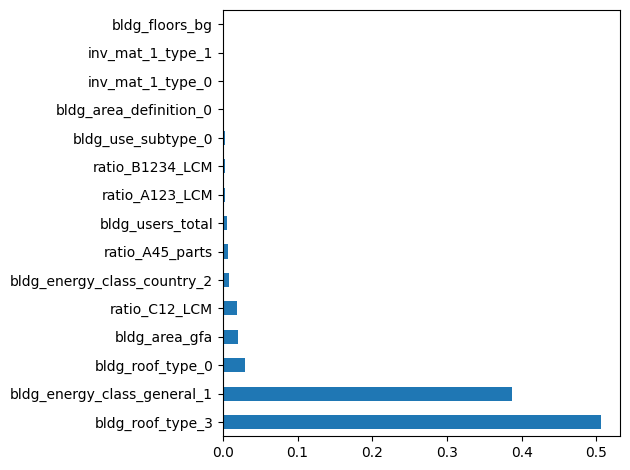

In [ ]:
multi_model(model_algorithm_dataset_dict,rand_seed=my_seed,default_hyper_params=True)

## 2.3 train models with hyperparams tuning

## 2.4 try ANN

In [ ]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import backend as K

In [ ]:
# define a custom metric for r2: https://jmlb.github.io/ml/2017/03/20/CoeffDetermination_CustomMetric4Keras/
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) ) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
# define model architecture
feat_input = Input(shape=(len(X_train.columns),))
GWP_pred = Dense(256, activation="relu")(feat_input)
GWP_pred = Dense(256, activation="relu")(GWP_pred)
GWP_pred = Dense(1)(GWP_pred)
model = Model(feat_input,GWP_pred)

# compile model
model.compile(loss= "mean_squared_error" , optimizer="adam", metrics=[coeff_determination])

# train model
model.fit(
    X_train,
    y_train,
    epochs=100,
    verbose=True,
)

# make prediction
pred_train= model.predict(X_train)
print(np.sqrt(mean_squared_error(y_train,pred_train)))

pred= model.predict(X_test)
print(np.sqrt(mean_squared_error(y_test,pred))) 

Epoch 1/100
3/3 [==============================] - 6s 9ms/step - loss: 272388014080.0000 - coeff_determination: -0.3534
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 272182886400.0000 - coeff_determination: -0.3631
Epoch 3/100
3/3 [==============================] - 0s 6ms/step - loss: 272003448832.0000 - coeff_determination: -0.3687
Epoch 4/100
3/3 [==============================] - 0s 6ms/step - loss: 271843065856.0000 - coeff_determination: -0.3479
Epoch 5/100
3/3 [==============================] - 0s 6ms/step - loss: 271629008896.0000 - coeff_determination: -0.3770
Epoch 6/100
3/3 [==============================] - 0s 6ms/step - loss: 271437545472.0000 - coeff_determination: -0.3555
Epoch 7/100
3/3 [==============================] - 0s 6ms/step - loss: 271223570432.0000 - coeff_determination: -0.3897
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 270962982912.0000 - coeff_determination: -0.3517
Epoch 9/100
3/3 [=======================

# 3.0 Feature importance analysis




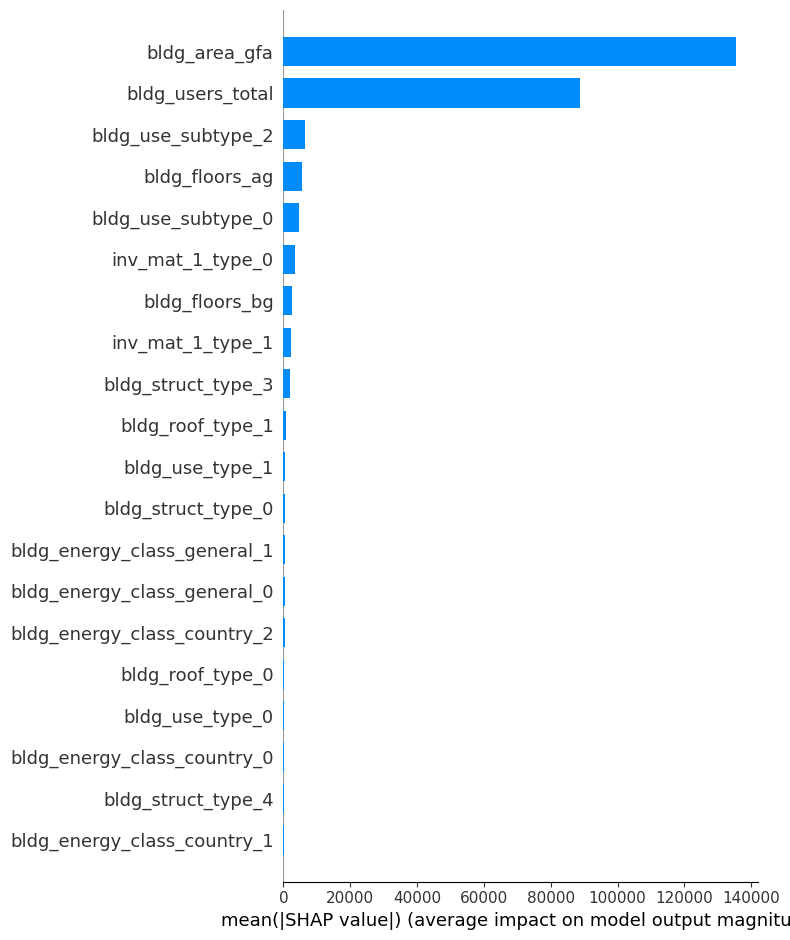

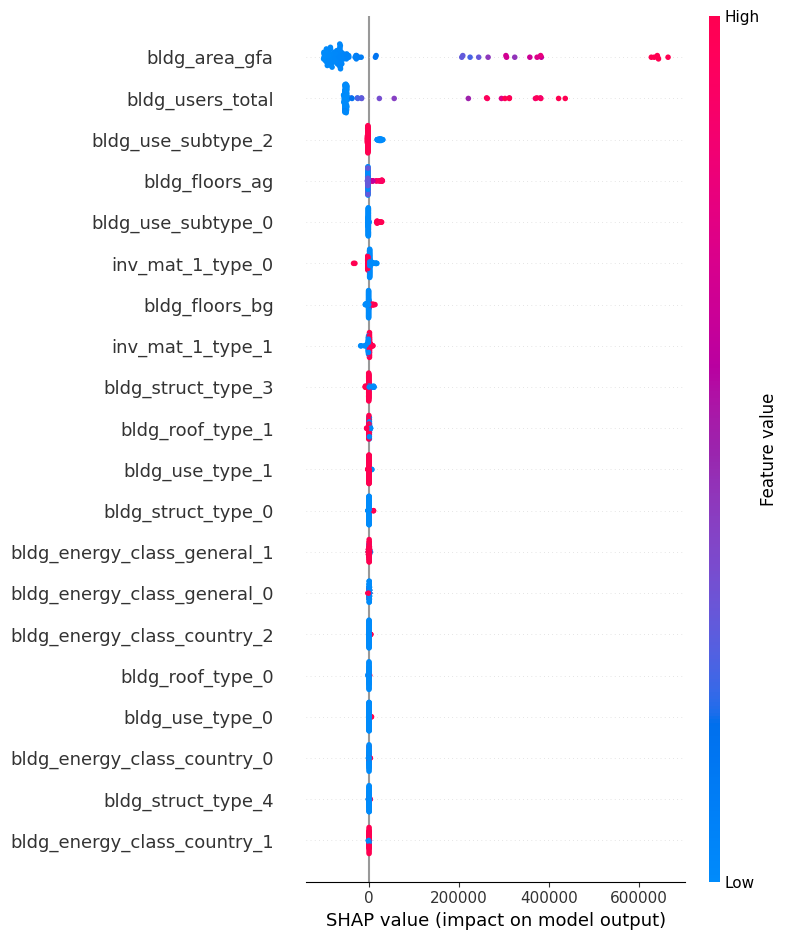

In [ ]:
# retrieve the model of interest
best_model_path = os.path.sep.join([os.getcwd(),f"BEST_performing_model.pkl"])
best_perform_model = pickle.load(open(best_model_path, 'rb'))

# perform SHAP analysis
data_input_for_anal = d_base_rf[0] # this points to X_train in baseline dataset for RF
SHAP_anal(best_perform_model, data_input_for_anal)